In [1]:
import pandas as pd
import numpy as np
import matplotlib as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Ra
from IPython.core.pylabtools import figsize
figsize(11, 9)
%matplotlib inline


In [177]:
df = pd.read_csv('/Users/MattKatz/Coding/GA/DAT-2017-03-20/DAT_03_20_Matt_Katz/Final_Project/Data/loan.csv', low_memory=False)

# Section 1: describing the dataset

In [196]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 887379 entries, 0 to 887378
Data columns (total 74 columns):
id                             887379 non-null int64
member_id                      887379 non-null int64
loan_amnt                      887379 non-null float64
funded_amnt                    887379 non-null float64
funded_amnt_inv                887379 non-null float64
term                           887379 non-null object
int_rate                       887379 non-null float64
installment                    887379 non-null float64
grade                          887379 non-null object
sub_grade                      887379 non-null object
emp_title                      835922 non-null object
emp_length                     887379 non-null object
home_ownership                 887379 non-null object
annual_inc                     887375 non-null float64
verification_status            887379 non-null object
issue_d                        887379 non-null object
loan_status          

In [3]:
columns_to_drop = ['member_id', 'funded_amnt_inv',
       'emp_title',
       'verification_status',
       'issue_d', 'pymnt_plan', 'url', 'desc', 
       'title', 'zip_code', 'delinq_2yrs',
       'earliest_cr_line', 'inq_last_6mths', 'mths_since_last_delinq',
       'mths_since_last_record', 'open_acc', 'pub_rec', 'total_acc', 'initial_list_status', 
       'out_prncp_inv',  'total_pymnt_inv', 
       'total_rec_int', 'total_rec_late_fee', 'recoveries', 'total_rec_prncp',
       'collection_recovery_fee', 'last_pymnt_d', 'last_pymnt_amnt',
       'next_pymnt_d', 'last_credit_pull_d', 'collections_12_mths_ex_med',
       'mths_since_last_major_derog', 'policy_code', 
        'verification_status_joint', 'home_ownership', 'revol_bal',
       'acc_now_delinq', 'tot_coll_amt',  'open_acc_6m', 'revol_util',
       'open_il_6m', 'open_il_12m', 'open_il_24m', 'mths_since_rcnt_il',
       'total_bal_il', 'il_util', 'open_rv_12m', 'open_rv_24m', 'max_bal_bc',
       'all_util', 'total_rev_hi_lim', 'inq_fi', 'total_cu_tl',
       'inq_last_12m']


df.drop(columns_to_drop, axis=1, inplace=True)

In [209]:
df.ix[:,0:21].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 887379 entries, 0 to 887378
Data columns (total 21 columns):
id                  887379 non-null int64
loan_amnt           887379 non-null float64
funded_amnt         887379 non-null float64
term                887379 non-null object
int_rate            887379 non-null float64
installment         887379 non-null float64
grade               887379 non-null object
sub_grade           887379 non-null object
emp_length          887379 non-null object
annual_inc          887375 non-null float64
loan_status         887379 non-null object
purpose             887379 non-null object
addr_state          887379 non-null object
dti                 887379 non-null float64
out_prncp           887379 non-null float64
total_pymnt         887379 non-null float64
application_type    887379 non-null object
annual_inc_joint    511 non-null float64
dti_joint           509 non-null float64
tot_cur_bal         817103 non-null float64
default             88737

# Section 2: Cleaning the data

### Boolean default variable

In [211]:
df.purpose.unique()

array(['credit_card', 'car', 'small_business', 'other', 'wedding',
       'debt_consolidation', 'home_improvement', 'major_purchase',
       'medical', 'moving', 'vacation', 'house', 'renewable_energy',
       'educational'], dtype=object)

In [210]:
df.loan_status.unique()

array(['Fully Paid', 'Charged Off', 'Current', 'Default',
       'Late (31-120 days)', 'In Grace Period', 'Late (16-30 days)',
       'Does not meet the credit policy. Status:Fully Paid',
       'Does not meet the credit policy. Status:Charged Off', 'Issued'], dtype=object)

In [5]:
#map the statuses to boolean variable
mapper = {'Fully Paid':0, 'Charged Off':1, 'Current':0, 'Default':1,
       'Late (31-120 days)':1, 'In Grace Period':0, 'Late (16-30 days)':1,
       'Does not meet the credit policy. Status:Fully Paid':0,
       'Does not meet the credit policy. Status:Charged Off':1, 'Issued':0}

In [6]:
#simplify loan status categories
df['default'] = df.loan_status
df = df.replace({"default":mapper})


### Removing credit score outliers

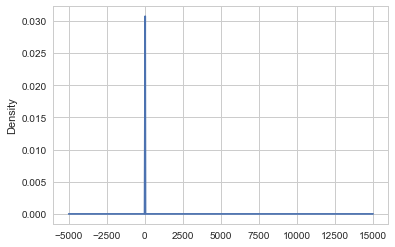

In [215]:
df2.dti.plot(kind='density')

In [220]:
ceiling = df.dti.mean() + df.dti.std() * 2.576
df.ix[df.dti > ceiling, 'dti'] = ceiling

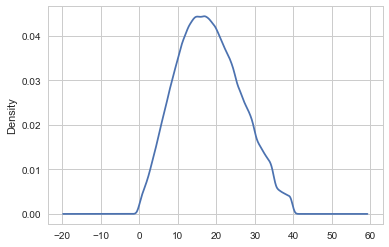

In [219]:
df.dti.plot(kind='density')

# Section 3: data exploration of default rates

In [214]:
df.default.mean()

0.06894010338310913

In [9]:
def summation(x):
    groupby1 = df.groupby(df[x]).default.sum()

    groupby1 = groupby1.to_frame(name="sum")
    groupby2 = df.groupby(df[x]).default.count()
    groupby2 = groupby2.to_frame(name="count")
    groupby1['count'] = groupby2['count']
    groupby1['pct'] = groupby1['sum'] / groupby1['count']

    sns.set_style("whitegrid")
    ax = sns.factorplot(y = 'pct', x = groupby1.index, data=groupby1,size=15,kind='bar')
    ax.set(xlabel = '', ylabel = '', title = x)
    

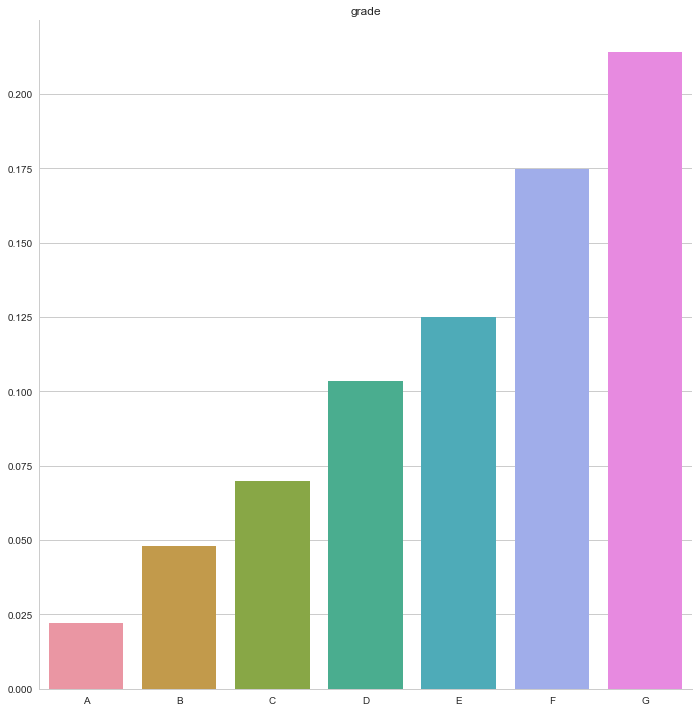

In [10]:
summation('grade')

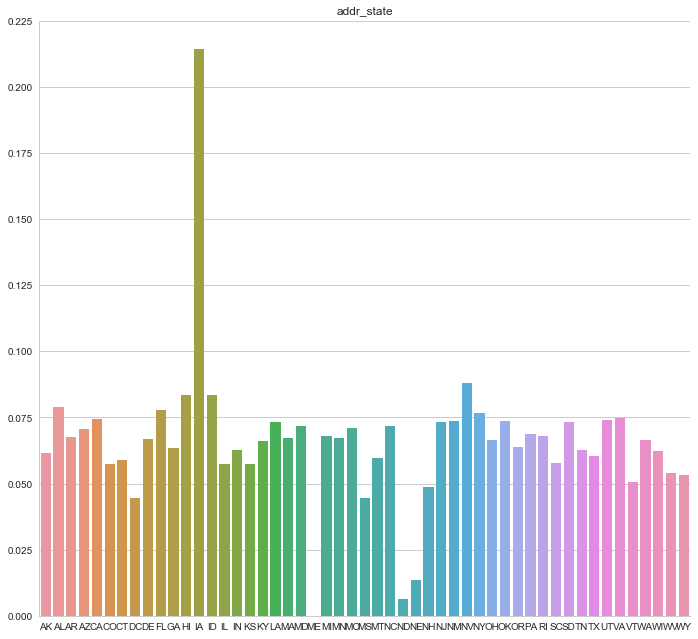

In [11]:
summation('addr_state')

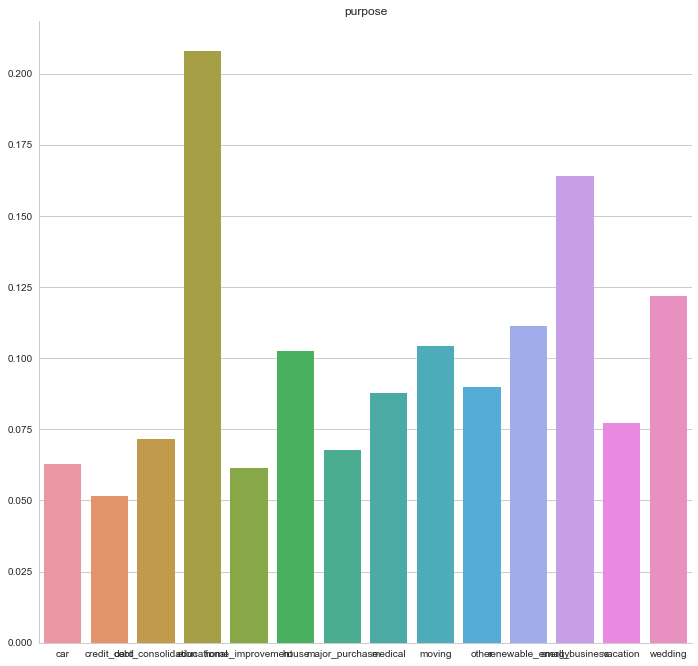

In [213]:
summation('purpose')

# Section 4: Building Models

### Building a logistic regression

In [16]:
df = df.join(pd.get_dummies(df.grade, prefix="grade"))
df['intercept'] = 1.0
df.columns

Index([u'id', u'loan_amnt', u'funded_amnt', u'term', u'int_rate',
       u'installment', u'grade', u'sub_grade', u'emp_length', u'annual_inc',
       u'loan_status', u'purpose', u'addr_state', u'dti', u'out_prncp',
       u'total_pymnt', u'application_type', u'annual_inc_joint', u'dti_joint',
       u'tot_cur_bal', u'default', u'grade_A', u'grade_B', u'grade_C',
       u'grade_D', u'grade_E', u'grade_F', u'grade_G', u'intercept'],
      dtype='object')

In [20]:
test_columns = ['dti', 'grade_B', 'grade_C',
               'grade_D', 'grade_E', 'grade_F', 'grade_G', 'int_rate', 'intercept']
df_test = df[test_columns]

lm = sm.Logit(df['default'], df_test)
lm_result = lm.fit()

Optimization terminated successfully.
         Current function value: 0.234710
         Iterations 8


In [21]:
print lm_result.summary()


                           Logit Regression Results                           
Dep. Variable:                default   No. Observations:               887379
Model:                          Logit   Df Residuals:                   887370
Method:                           MLE   Df Model:                            8
Date:                Tue, 23 May 2017   Pseudo R-squ.:                 0.06449
Time:                        19:45:30   Log-Likelihood:            -2.0828e+05
converged:                       True   LL-Null:                   -2.2263e+05
                                        LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
dti           -0.0016      0.001     -3.129      0.002        -0.003    -0.001
grade_B       -0.4616      0.024    -19.447      0.000        -0.508    -0.415
grade_C       -1.0912      0.030    -36.543      0.0

In [22]:
conf = lm_result.conf_int()
conf['OR'] = lm_result.params
conf.columns = ['2.5%', '97.5%', 'OR']
np.exp(conf)

,2.5%,97.5%,OR
dti,0.997377,0.999397,0.998386
grade_B,0.601608,0.660274,0.630259
grade_C,0.316736,0.356066,0.335826
grade_D,0.165257,0.192201,0.178220
grade_E,0.078636,0.094695,0.086293
grade_F,0.033564,0.042393,0.037721
grade_G,0.020500,0.027192,0.023610
int_rate,1.390412,1.408421,1.399388
intercept,0.001830,0.002071,0.001947


## Using grid search and cross validation

In [174]:
from sklearn import grid_search, cross_validation

gs = grid_search.GridSearchCV(
    estimator=LogisticRegression(),
    param_grid={'C': [1, 50, 100]},
    cv=cross_validation.KFold(n=len(df_test), n_folds=5),
    scoring='roc_auc'
)

gs.fit(df_test, df['default'])
gs.grid_scores_

[mean: 0.68277, std: 0.04322, params: {'C': 1},
 mean: 0.68257, std: 0.04350, params: {'C': 50},
 mean: 0.68254, std: 0.04351, params: {'C': 100}]

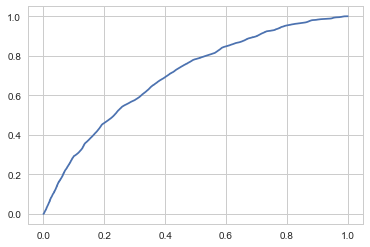

In [44]:
predictions_logistic = gs.best_estimator_.predict(df[test_columns])

probas_logistic = gs.best_estimator_.predict_proba(df[test_columns])

pyplt.plot(roc_curve(df[['default']], probas_logistic[:,1])[0], roc_curve(df[['default']], probas_logistic[:,1])[1])

In [45]:
print classification_report(df['default'], predictions_logistic, target_names=['current', 'default'])

             precision    recall  f1-score   support

    current       0.93      1.00      0.96    826203
    default       0.00      0.00      0.00     61176

avg / total       0.87      0.93      0.90    887379



## Building a random forest model, with grid search and CV

In [175]:
#random forest
from sklearn.ensemble import RandomForestClassifier

gs = grid_search.GridSearchCV(
    estimator=RandomForestClassifier(),
    param_grid={'n_estimators': [20, 100]},
    cv=cross_validation.KFold(n=len(df_test), n_folds=5),
    scoring='roc_auc'
)

gs.fit(df_test, df['default'])
gs.grid_scores_

[mean: 0.55353, std: 0.00535, params: {'n_estimators': 20},
 mean: 0.56909, std: 0.00617, params: {'n_estimators': 100}]

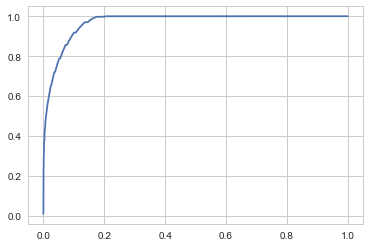

In [118]:
predictions_rf = gs.best_estimator_.predict(df[test_columns])

probas_rf = gs.best_estimator_.predict_proba(df[test_columns])

pyplt.plot(roc_curve(df[['default']], probas_rf[:,1])[0], roc_curve(df[['default']], probas_rf[:,1])[1])

In [119]:
print classification_report(df['default'], predictions_rf, target_names=['current', 'default'])

             precision    recall  f1-score   support

    current       0.96      0.99      0.98    826203
    default       0.85      0.45      0.59     61176

avg / total       0.95      0.96      0.95    887379



## Comparing the model default predictions

In [130]:
#add columns to the dataframe
df['rf_probas'] = probas_rf[:,1]
df['logistic_probas'] = probas_logistic[:,1]

In [173]:
groupby_log = df.groupby(df.grade)['logistic_probas'].mean()
groupby_rf = df.groupby(df.grade)['rf_probas'].mean()

prob_means = groupby_log.to_frame(name="log")
prob_means['rf'] = groupby_rf.to_frame(name="rf")


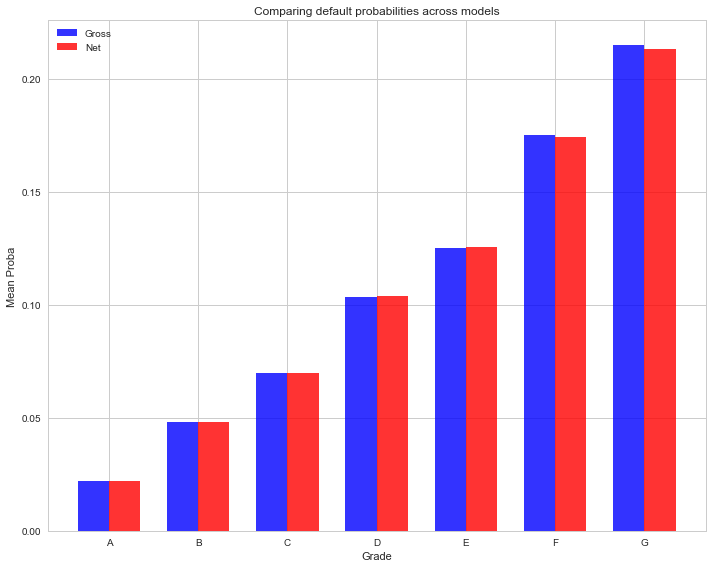

In [187]:
import matplotlib.pyplot as plt

n_groups = len(prob_means)

log = prob_means.log

rf = prob_means.rf

fig, ax = plt.subplots(figsize=(10,8))

index = np.arange(n_groups)
bar_width = 0.35

opacity = 0.8

rects1 = plt.bar(index, log, bar_width,
                 alpha=opacity,
                 color='b',
                 label='Gross')

rects2 = plt.bar(index + bar_width, rf, bar_width,
                 alpha=opacity,
                 color='r',
                 label='Net')

plt.xlabel('Grade')
plt.ylabel('Mean Proba')
plt.title('Comparing default probabilities across models')
plt.xticks(index + bar_width / 2, ('A', 'B', 'C', 'D', 'E', 'F', 'G'))
plt.legend()

plt.tight_layout()
plt.show()

# Section 5: But should I invest in Lending Club loans?

In [166]:
int_rate_table = pd.DataFrame(index=range(1,len(df.grade.unique()) + 1), columns=['grade','gross_int_rate', 'perc_default', 'net_return'])

recovery = 0

grades = df.grade.unique()

for x in enumerate(grades):
    int_rate_table['grade'].iloc[x[0]] = x[1]
    int_rate_table['gross_int_rate'].iloc[x[0]] = df[(df.grade == x[1])].int_rate.sum() / len(df[(df.grade == x[1])])
    perc_default_temp = df[(df.grade == x[1])].default.mean()
    int_rate_table['perc_default'].iloc[x[0]] = perc_default_temp
    int_rate_table['net_return'].iloc[x[0]] = df[(df.grade == x[1]) ].int_rate.sum() / len(df[(df.grade == x[1])]) - 100 * perc_default_temp

int_rate_table = int_rate_table.sort(columns='grade')
int_rate_table
#look at what the net takehome would have been had you correctly avoided the loan

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:14: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


,grade,gross_int_rate,perc_default,net_return
3,A,7.24331,0.0222534,5.01797
1,B,10.8296,0.0479934,6.03028
2,C,13.9801,0.0698243,6.99767
6,D,17.1758,0.103582,6.81764
4,E,19.8973,0.124984,7.39891
5,F,23.5828,0.174824,6.10036
7,G,25.6267,0.214064,4.22026


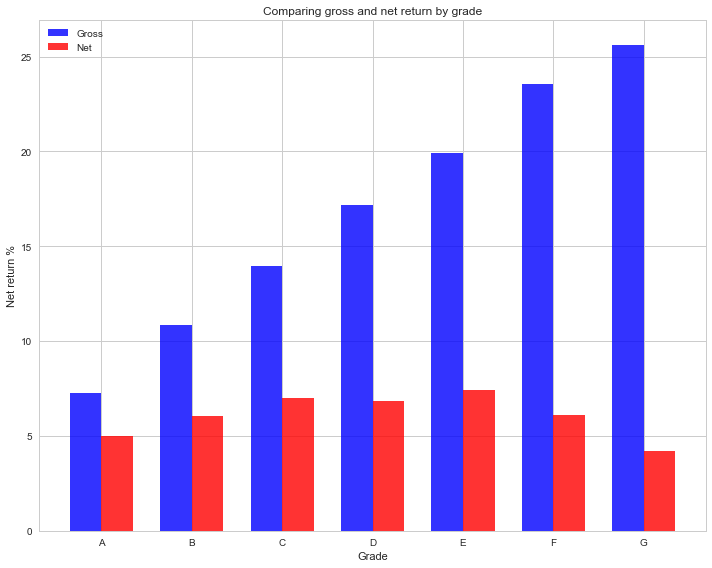

,grade,gross_int_rate,perc_default,net_return
3,A,7.24331,0.0222534,5.01797
1,B,10.8296,0.0479934,6.03028
2,C,13.9801,0.0698243,6.99767
6,D,17.1758,0.103582,6.81764
4,E,19.8973,0.124984,7.39891
5,F,23.5828,0.174824,6.10036
7,G,25.6267,0.214064,4.22026


In [222]:
import matplotlib.pyplot as plt

n_groups = len(int_rate_table.net_return)

gross_return = int_rate_table.gross_int_rate

net_return = int_rate_table.net_return

fig, ax = plt.subplots(figsize=(10,8))

index = np.arange(n_groups)
bar_width = 0.35

opacity = 0.8

rects1 = plt.bar(index, gross_return, bar_width,
                 alpha=opacity,
                 color='b',
                 label='Gross')

rects2 = plt.bar(index + bar_width, net_return, bar_width,
                 alpha=opacity,
                 color='r',
                 label='Net')

plt.xlabel('Grade')
plt.ylabel('Net return %')
plt.title('Comparing gross and net return by grade')
plt.xticks(index + bar_width / 2, ('A', 'B', 'C', 'D', 'E', 'F', 'G'))
plt.legend()

plt.tight_layout()
plt.show()
int_rate_table

# Do the predictive models help avoid defaults?

### Logistic regression

In [111]:
log_int_rate_table = pd.DataFrame(index=range(1,len(df.grade.unique()) + 1), columns=['grade','gross_int_rate', 'perc_default', 'net_return'])


for x in enumerate(grades):
    log_int_rate_table['grade'].iloc[x[0]] = x[1]
    ceiling = df[df.grade == x[1]].logistic_probas.mean() + df[df.grade == x[1]].logistic_probas.std() * 1.96
    log_int_rate_table['gross_int_rate'].iloc[x[0]] = df[(df.grade == x[1]) & (df.logistic_probas < ceiling)].int_rate.mean()
    perc_default_temp = df[(df.grade == x[1]) & (df.logistic_probas < ceiling)].default.mean()
    log_int_rate_table['perc_default'].iloc[x[0]] = perc_default_temp

log_int_rate_table['net_return'] = log_int_rate_table.gross_int_rate - (100 * log_int_rate_table.perc_default)
    
log_int_rate_table = log_int_rate_table.sort(columns='grade')
log_int_rate_table['improvement'] = log_int_rate_table['net_return'] - int_rate_table['net_return']
log_int_rate_table

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:13: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


,grade,gross_int_rate,perc_default,net_return,improvement
3,A,7.10609,0.0193773,5.16836,0.150385
1,B,10.719,0.0451844,6.20056,0.170284
2,C,13.7977,0.0634753,7.4502,0.452531
6,D,17.0224,0.0987597,7.14644,0.328795
4,E,19.7425,0.119157,7.82682,0.427909
5,F,23.5286,0.177796,5.74906,-0.351295
7,G,25.4788,0.21974,3.50477,-0.715484


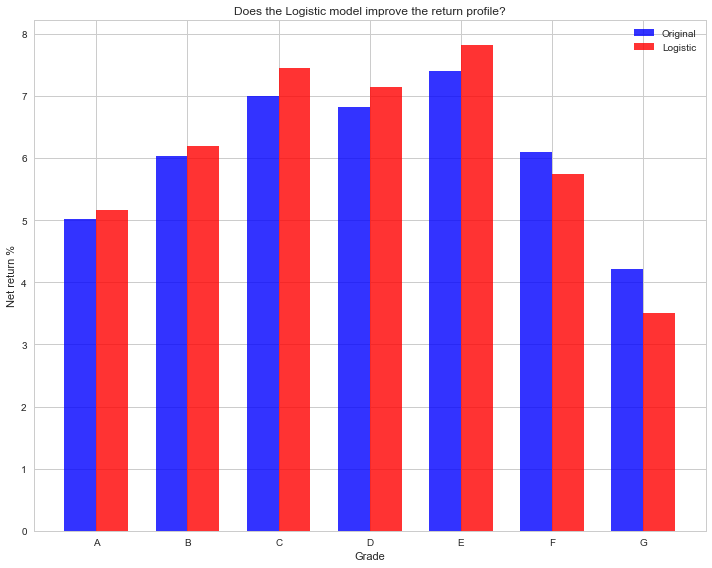

,grade,gross_int_rate,perc_default,net_return,improvement
3,A,7.10609,0.0193773,5.16836,0.150385
1,B,10.719,0.0451844,6.20056,0.170284
2,C,13.7977,0.0634753,7.4502,0.452531
6,D,17.0224,0.0987597,7.14644,0.328795
4,E,19.7425,0.119157,7.82682,0.427909
5,F,23.5286,0.177796,5.74906,-0.351295
7,G,25.4788,0.21974,3.50477,-0.715484


In [223]:
n_groups = len(int_rate_table.net_return)

net_return = int_rate_table.net_return

log_net_return = log_int_rate_table.net_return

fig, ax = plt.subplots(figsize=(10,8))

index = np.arange(n_groups)
bar_width = 0.35

opacity = 0.8

rects1 = plt.bar(index, net_return, bar_width,
                 alpha=opacity,
                 color='b',
                 label='Original')

rects2 = plt.bar(index + bar_width, log_net_return, bar_width,
                 alpha=opacity,
                 color='r',
                 label='Logistic')

plt.xlabel('Grade')
plt.ylabel('Net return %')
plt.title('Does the Logistic model improve the return profile?')
plt.xticks(index + bar_width / 2, ('A', 'B', 'C', 'D', 'E', 'F', 'G'))
plt.legend()

plt.tight_layout()
plt.show()
log_int_rate_table

### Random Forest Model

In [132]:
rf_int_rate_table = pd.DataFrame(index=range(1,len(df.grade.unique()) + 1), columns=['grade','gross_int_rate', 'perc_default', 'net_return'])


for x in enumerate(grades):
    rf_int_rate_table['grade'].iloc[x[0]] = x[1]
    ceiling = df[df.grade == x[1]].rf_probas.mean() + df[df.grade == x[1]].rf_probas.std() * 1.96
    rf_int_rate_table['gross_int_rate'].iloc[x[0]] = df[(df.grade == x[1]) & (df.rf_probas < ceiling)].int_rate.mean()
    perc_default_temp = df[(df.grade == x[1]) & (df.rf_probas < ceiling)].default.mean()
    rf_int_rate_table['perc_default'].iloc[x[0]] = perc_default_temp

rf_int_rate_table['net_return'] = rf_int_rate_table.gross_int_rate - (100 * rf_int_rate_table.perc_default)
    
rf_int_rate_table = rf_int_rate_table.sort(columns='grade')
rf_int_rate_table['improvement'] = rf_int_rate_table['net_return'] - int_rate_table['net_return']
rf_int_rate_table

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:13: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


,grade,gross_int_rate,perc_default,net_return,improvement
3,A,7.21685,0.00472956,6.74389,1.72592
1,B,10.7673,0.0197988,8.78739,2.75711
2,C,13.9196,0.0326765,10.652,3.65432
6,D,17.1295,0.0533743,11.7921,4.97447
4,E,19.8514,0.0602918,13.8223,6.42334
5,F,23.6156,0.102107,13.4048,7.30448
7,G,25.7008,0.153288,10.372,6.15174


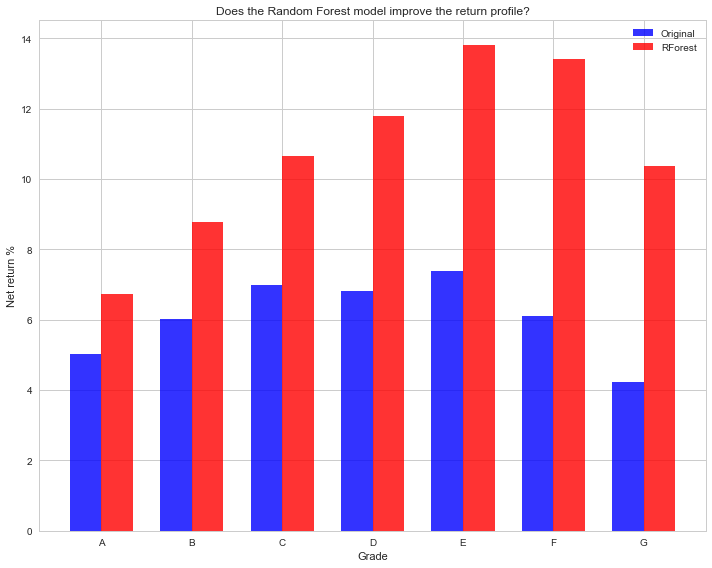

,grade,gross_int_rate,perc_default,net_return,improvement
3,A,7.21685,0.00472956,6.74389,1.72592
1,B,10.7673,0.0197988,8.78739,2.75711
2,C,13.9196,0.0326765,10.652,3.65432
6,D,17.1295,0.0533743,11.7921,4.97447
4,E,19.8514,0.0602918,13.8223,6.42334
5,F,23.6156,0.102107,13.4048,7.30448
7,G,25.7008,0.153288,10.372,6.15174


In [224]:
n_groups = len(int_rate_table.net_return)

net_return = int_rate_table.net_return

rf_net_return = rf_int_rate_table.net_return

fig, ax = plt.subplots(figsize=(10,8))

index = np.arange(n_groups)
bar_width = 0.35

opacity = 0.8

rects1 = plt.bar(index, net_return, bar_width,
                 alpha=opacity,
                 color='b',
                 label='Original')

rects2 = plt.bar(index + bar_width, rf_net_return, bar_width,
                 alpha=opacity,
                 color='r',
                 label='RForest')

plt.xlabel('Grade')
plt.ylabel('Net return %')
plt.title('Does the Random Forest model improve the return profile?')
plt.xticks(index + bar_width / 2, ('A', 'B', 'C', 'D', 'E', 'F', 'G'))
plt.legend()

plt.tight_layout()
plt.show()
rf_int_rate_table

## How do the two models compare?

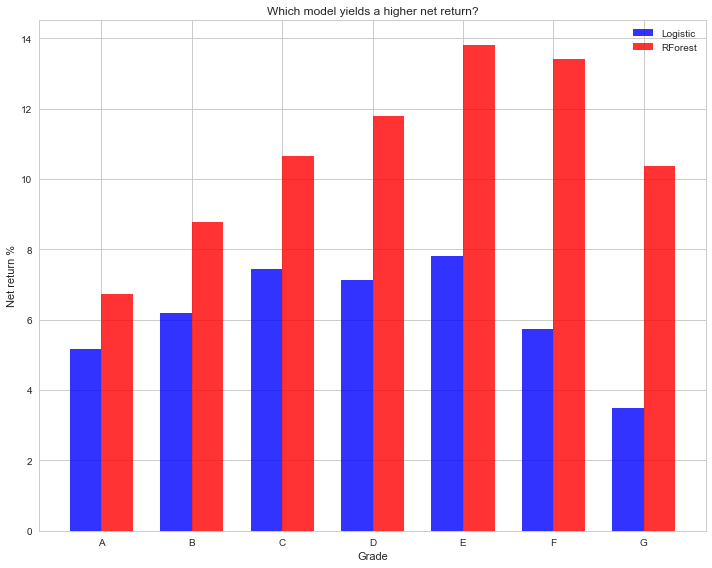

In [191]:
import matplotlib.pyplot as plt

n_groups = len(log_int_rate_table.net_return)

log_net_return = log_int_rate_table.net_return


rf_net_return = rf_int_rate_table.net_return

fig, ax = plt.subplots(figsize=(10,8))

index = np.arange(n_groups)
bar_width = 0.35

opacity = 0.8

rects1 = plt.bar(index, log_net_return, bar_width,
                 alpha=opacity,
                 color='b',
                 label='Logistic')

rects2 = plt.bar(index + bar_width, rf_net_return, bar_width,
                 alpha=opacity,
                 color='r',
                 label='RForest')

plt.xlabel('Grade')
plt.ylabel('Net return %')
plt.title('Which model yields a higher net return?')
plt.xticks(index + bar_width / 2, ('A', 'B', 'C', 'D', 'E', 'F', 'G'))
plt.legend()

plt.tight_layout()
plt.show()


## Using Random Forest, which tranche should I invest in?

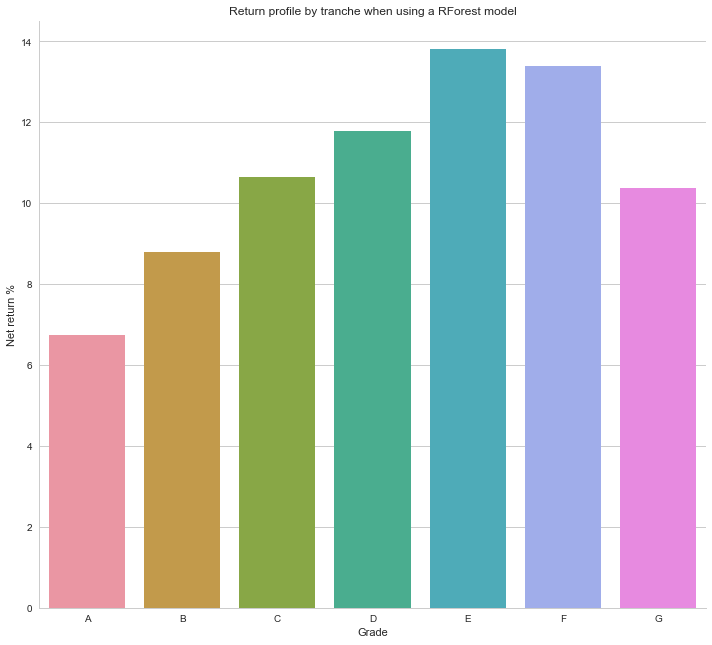

In [164]:
sns.set_style("whitegrid")
ax = sns.factorplot(y = 'net_return', x = rf_int_rate_table.grade, data=rf_int_rate_table,size=10,kind='bar')
ax.set(xlabel = 'Grade', ylabel = 'Net return %', title = 'Return profile by tranche when using a RForest model')

In [226]:
rf_int_rate_table.net_return.mean()

10.796354193170723